# Converting CPTECs MERGE files

Author     : MJT (mjt@if.usp.br)

Institution: RCGI / IFUSP

Date       : 24-May-2022

Version    : PA4

- taking the average of multiple merged files (montly)
- Exporting this processed file to tiff using cube


Date       : 18-May-2022

Version    : PA3

- Cleaning code for performance
- Including Poligon for grids

Date       : 05-May-2022

Version    : PA2

- Box to select data only from South America

Date       : 27-Apr-2022

Version    : PA1

- initial version of this code

Cuidados a se tomar com os GRIBs:
1. verificar a latitude e longitude. Caso não estejam no intervalo [-180,180] fazer a transformação
2. Desenhar os polígonos

In [10]:
import os 
import xarray as xr
# import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

In [20]:
# time calculation for benchmarking 

# import time
# start_time = time.time()

# open GRIB file 

filename = '/home/mapbiomasar/MJT/CPTEC/10/oct2000.grib2'
cptec_file = xr.open_dataset(filename,engine = 'cfgrib')




In [21]:
cptec_file

<xarray.Dataset>
Dimensions:     (time: 31, latitude: 924, longitude: 1001)
Coordinates:
  * time        (time) datetime64[ns] 2000-10-01T12:00:00 ... 2000-10-31T12:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    prec        (time, latitude, longitude) float32 ...
    prmsl       (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2022-05-24T09:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [12]:

df = cptec_file.prec.to_dataframe()

df = df.reset_index()
df = df[['time','latitude','longitude','prec']]
# Remaping longitudes

longs = df['longitude']
map_function = lambda lon: (lon - 360) if (lon > 180) else lon
remapped_longs = longs.map(map_function)
df["longitude"] = remapped_longs
df

,time,latitude,longitude,prec
0,2000-10-01 12:00:00,-60.05,-120.05,1.00
1,2000-10-01 12:00:00,-60.05,-119.95,0.75
2,2000-10-01 12:00:00,-60.05,-119.85,0.75
3,2000-10-01 12:00:00,-60.05,-119.75,4.75
4,2000-10-01 12:00:00,-60.05,-119.65,4.75
...,...,...,...,...
28672639,2000-10-31 12:00:00,32.25,-20.45,0.00
28672640,2000-10-31 12:00:00,32.25,-20.35,0.00
28672641,2000-10-31 12:00:00,32.25,-20.25,0.00
28672642,2000-10-31 12:00:00,32.25,-20.15,0.00


In [13]:
# agregating (monthly average)

# summarizing table
print(len(df))
tmp = df.groupby(['latitude','longitude'])['prec'].mean()
print(len(tmp))

df = tmp.reset_index().copy()
print(len(df))
# reset dbs
# cptec_file = None
tmp = None
df


28672644
924924
924924


,latitude,longitude,prec
0,-60.05,-120.05,3.129032
1,-60.05,-119.95,2.774194
2,-60.05,-119.85,2.729839
3,-60.05,-119.75,2.778226
4,-60.05,-119.65,2.854839
...,...,...,...
924919,32.25,-20.45,0.227823
924920,32.25,-20.35,0.254032
924921,32.25,-20.25,0.201613
924922,32.25,-20.15,0.137097


In [14]:
# to avoid excessive processing to shapefiles we define a box
# covering South America

min_lat = -57.5858
max_lat =  15.5988
min_lon = -85.8360
max_lon = -35.8750


# back to original nomenclature
df_clip = df.copy()

lat_filter = (df_clip["latitude"] >= min_lat) & (df_clip["latitude"] <= max_lat)
lon_filter = (df_clip["longitude"] >= min_lon) & (df_clip["longitude"] <= max_lon)

# df_clip = df_clip.loc[lat_filter & lon_filter]

df_clip = df_clip[lat_filter & lon_filter]
print(len(df_clip))

df = df_clip

df_clip = None
df

365268


,latitude,longitude,prec
25368,-57.55,-85.75,3.955645
25369,-57.55,-85.65,4.076613
25370,-57.55,-85.55,4.278226
25371,-57.55,-85.45,4.153226
25372,-57.55,-85.35,3.826613
...,...,...,...
757593,15.55,-36.35,0.661290
757594,15.55,-36.25,0.798387
757595,15.55,-36.15,1.125000
757596,15.55,-36.05,0.733871


In [15]:
# converting to vector using geopandas 

import geopandas as gpd 
from shapely.geometry import Polygon, Point, MultiPolygon

# converting to geopandas
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)

geo_df



/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,latitude,longitude,prec,geometry
25368,-57.55,-85.75,3.955645,POINT (-85.75000 -57.55000)
25369,-57.55,-85.65,4.076613,POINT (-85.65000 -57.55000)
25370,-57.55,-85.55,4.278226,POINT (-85.55000 -57.55000)
25371,-57.55,-85.45,4.153226,POINT (-85.45000 -57.55000)
25372,-57.55,-85.35,3.826613,POINT (-85.35000 -57.55000)
...,...,...,...,...
757593,15.55,-36.35,0.661290,POINT (-36.35000 15.55000)
757594,15.55,-36.25,0.798387,POINT (-36.25000 15.55000)
757595,15.55,-36.15,1.125000,POINT (-36.15000 15.55000)
757596,15.55,-36.05,0.733871,POINT (-36.05000 15.55000)


In [16]:
buffers = geo_df.buffer(0.5) # draw a 0.5 degree square
bounds = buffers.bounds

bounds['pixel_area'] = bounds.apply(
  lambda obj: Polygon(shell=[
    Point(obj['maxx'],obj['miny']),
    Point(obj['minx'],obj['miny']),
    Point(obj['minx'],obj['maxy']),
    Point(obj['maxx'],obj['maxy']),
    Point(obj['maxx'],obj['miny']),
  ]),
  axis=1
)

# adding indexes to merge dataframes
geo_df.insert(0, 'New_ID', range(1, 1 + len(geo_df)))
bounds.insert(0, 'New_ID', range(1, 1 + len(bounds)))

my_merge = bounds.merge(geo_df, on='New_ID')



/tmp/ipykernel_37712/1867172557.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers = geo_df.buffer(0.5) # draw a 0.5 degree square


In [17]:
# new geopandas with the variables of interest
gdf = my_merge.copy()
gdf = gpd.GeoDataFrame(
  gdf,
  crs = crs, 
  geometry = [a for a in gdf['pixel_area']]                               
  )
gdf = gdf.reset_index()
gdf = gdf.loc[:,gdf.columns.isin(['prec', 'geometry'])]

# print('--> TYPE: ',type(gdf))
# my_merge = None
gdf


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,prec,geometry
0,3.955645,"POLYGON ((-85.25000 -58.05000, -86.25000 -58.0..."
1,4.076613,"POLYGON ((-85.15000 -58.05000, -86.15000 -58.0..."
2,4.278226,"POLYGON ((-85.05000 -58.05000, -86.05000 -58.0..."
3,4.153226,"POLYGON ((-84.95000 -58.05000, -85.95000 -58.0..."
4,3.826613,"POLYGON ((-84.85000 -58.05000, -85.85000 -58.0..."
...,...,...
365263,0.661290,"POLYGON ((-35.85000 15.05000, -36.85000 15.050..."
365264,0.798387,"POLYGON ((-35.75000 15.05000, -36.75000 15.050..."
365265,1.125000,"POLYGON ((-35.65000 15.05000, -36.65000 15.050..."
365266,0.733871,"POLYGON ((-35.55000 15.05000, -36.55000 15.050..."


In [28]:
from geocube.api.core import make_geocube

cube = make_geocube(vector_data=gdf,resolution=(1, -1))


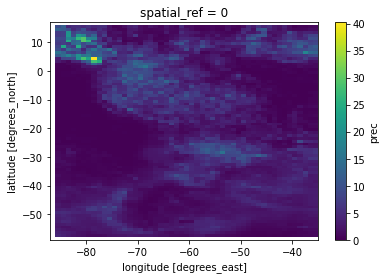

In [30]:
cube.prec.plot()


In [31]:
# time to convert the DF to raster

import rioxarray as rio

cube.prec.rio.to_raster('/home/mapbiomasar/MJT/CPTEC/10/oct2000_cube.tiff')
